# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Rémi Flamary

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yuanjie"
ln1 = "ZHAO"
fn2 = "Liyao"
ln2 = "JIAO"

filename = (
    "_".join(map(lambda s: s.strip().lower(), ["tp_newton", ln1, fn1, "and", ln2, fn2]))
    + ".ipynb"
)
print(filename)

# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, -grad_x, grad_x, c1=c1, c2=c2
        )
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


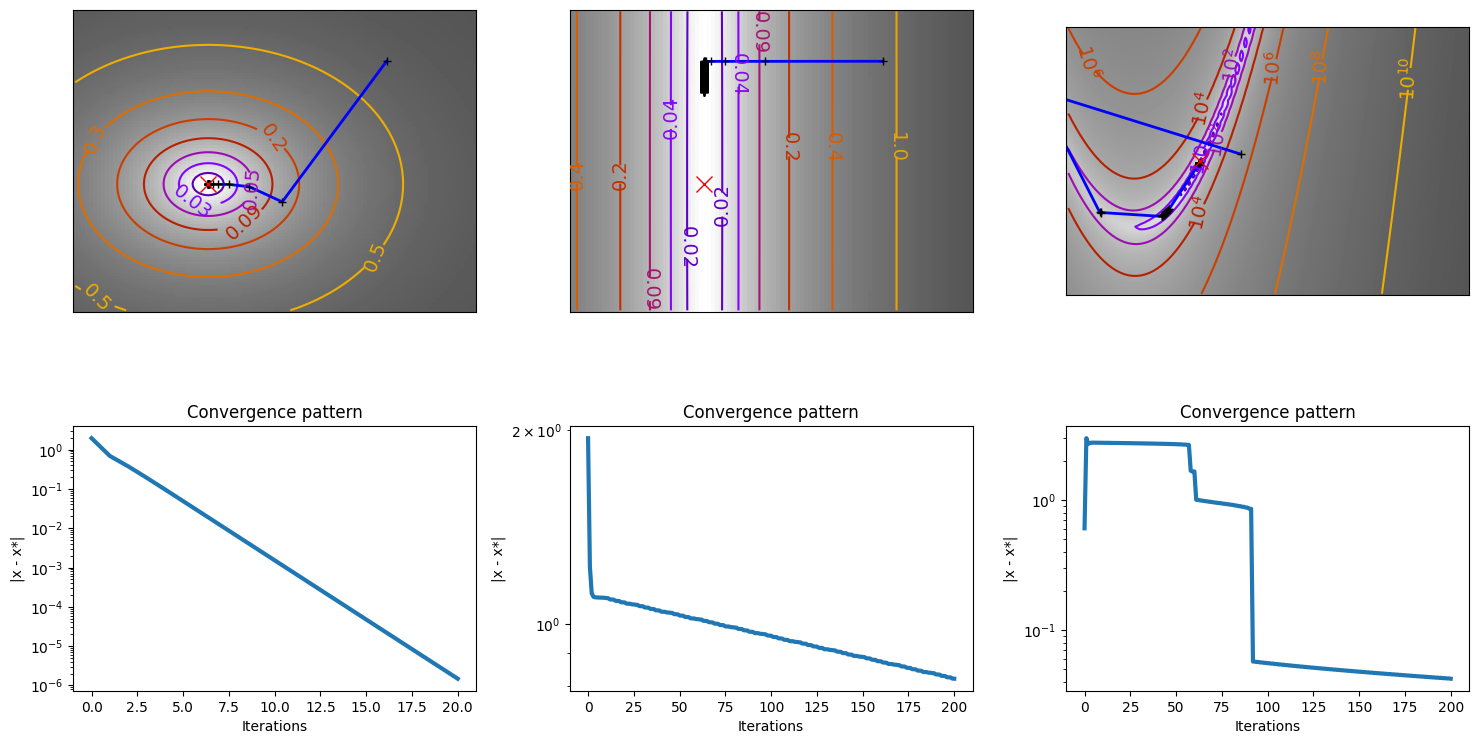

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [6]:
from scipy import linalg


def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001  # regularization threshold

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute the Hessian, regularize it and compute the search direction d

        # TODO H = ..
        # H = f_hessian(x) + lambda_threshold * np.eye(x.shape[0])
        
        H = f_hessian(x)

        eigenvals = np.linalg.eigvalsh(H)
        
        if min(eigenvals) < lambda_threshold :
            H+= (lambda_threshold - min(eigenvals))* np.eye(H.shape[0])

        d = np.linalg.solve(H, -grad_x)  # d = - H.inv * grad_xq

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


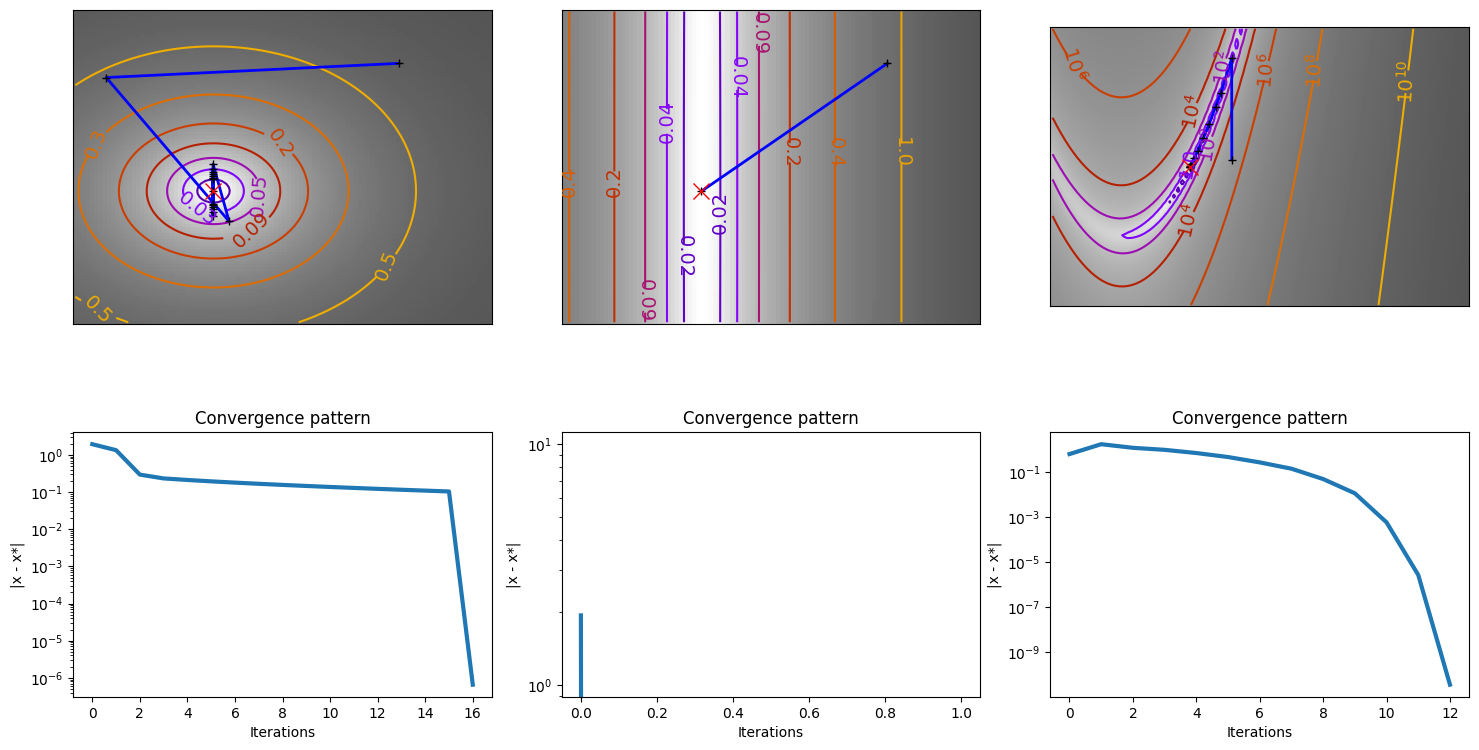

In [7]:
test_solver(newton)

WRITE YOUR COMMENTS HERE

We know that `x0 = np.array([1.6, 1.1])` inside `test_solver()`
1. For Gaussian Function ($\sigma = 1.4$), the convergence rate aligns with the theoretical results. When the initial point, $x_0$, is far from the optimal solution, $x^*$, the convergence rate is slow at first. As $x$ approaches $x^*$, the convergence rate increases, and the process converges more quickly.
2. For Quadratic Function, the newton method converges in one step, which matches the theory.
3. For Rosenbrock Function, `sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)`, this convegence rate is fast from the start point defined inside `test_solver`. 

---

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation

        # TODO B = ...
        B = B + np.outer(s,s) / np.dot(s, y) - np.outer(B @ y, B @ y) / np.dot(y, B @ y)
        
        ################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


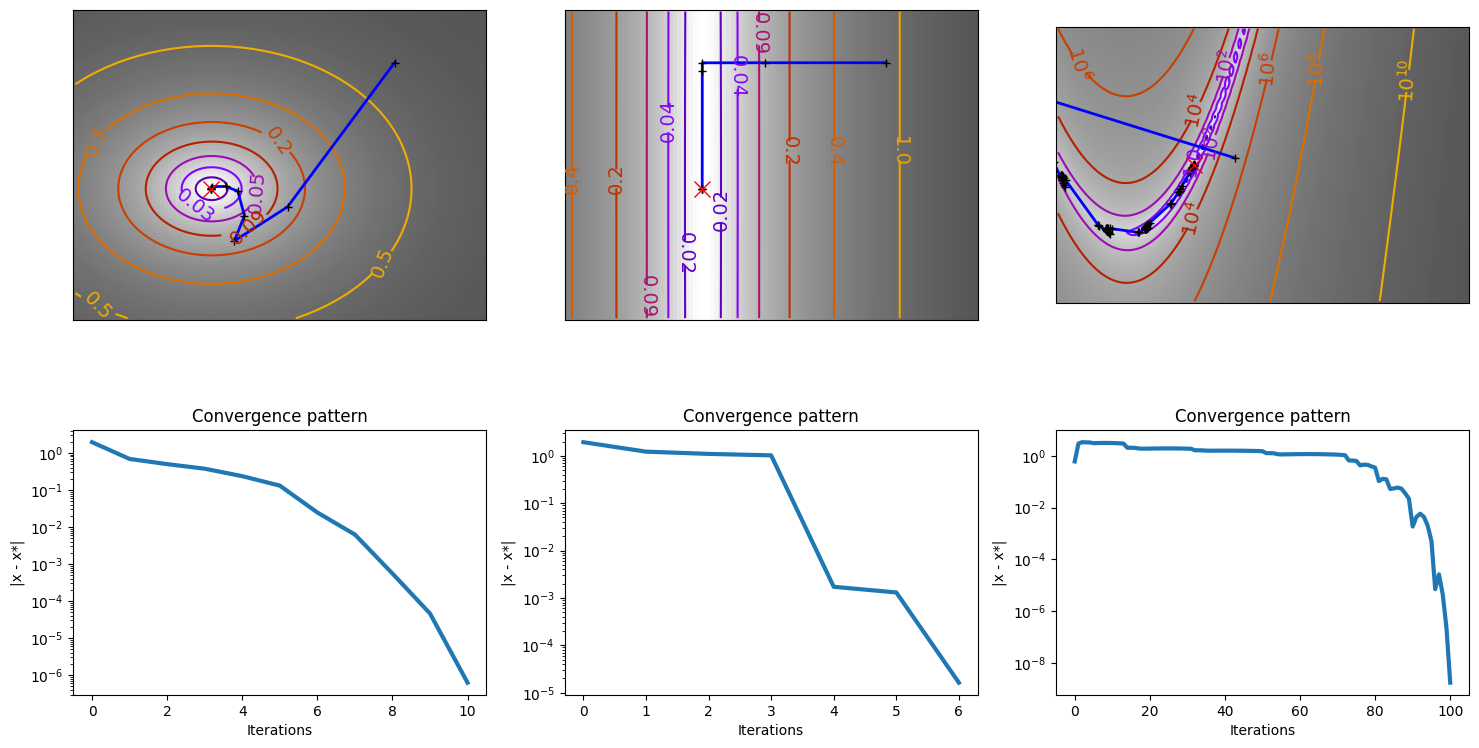

In [9]:
test_solver(dfp)

WRITE YOUR COMMENTS HERE

We know that `x0 = np.array([1.6, 1.1])` inside `test_solver()`
1. For Gaussian Function ($\sigma = 1.4$), the convergence rate is faster at the first steps. Which is influenced by the defination of $B_0$.
2. For Quadratic Function, the DFP method converges in many steps.
3. For Rosenbrock Function, `sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)`, this method use 100 iterations to get the error smaller than $10^{-10}$. It's not accurate to approximate the Hessian Matrix with this method.


# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [12]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation

        # TODO B =
        
        B = (np.eye(len(x)) - np.outer(s, y) / np.dot(y, s)) @ B @ (np.eye(len(x)) - np.outer(y, s) / np.dot(y, s)) + np.outer(s, s) / np.dot(y, s)
        
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


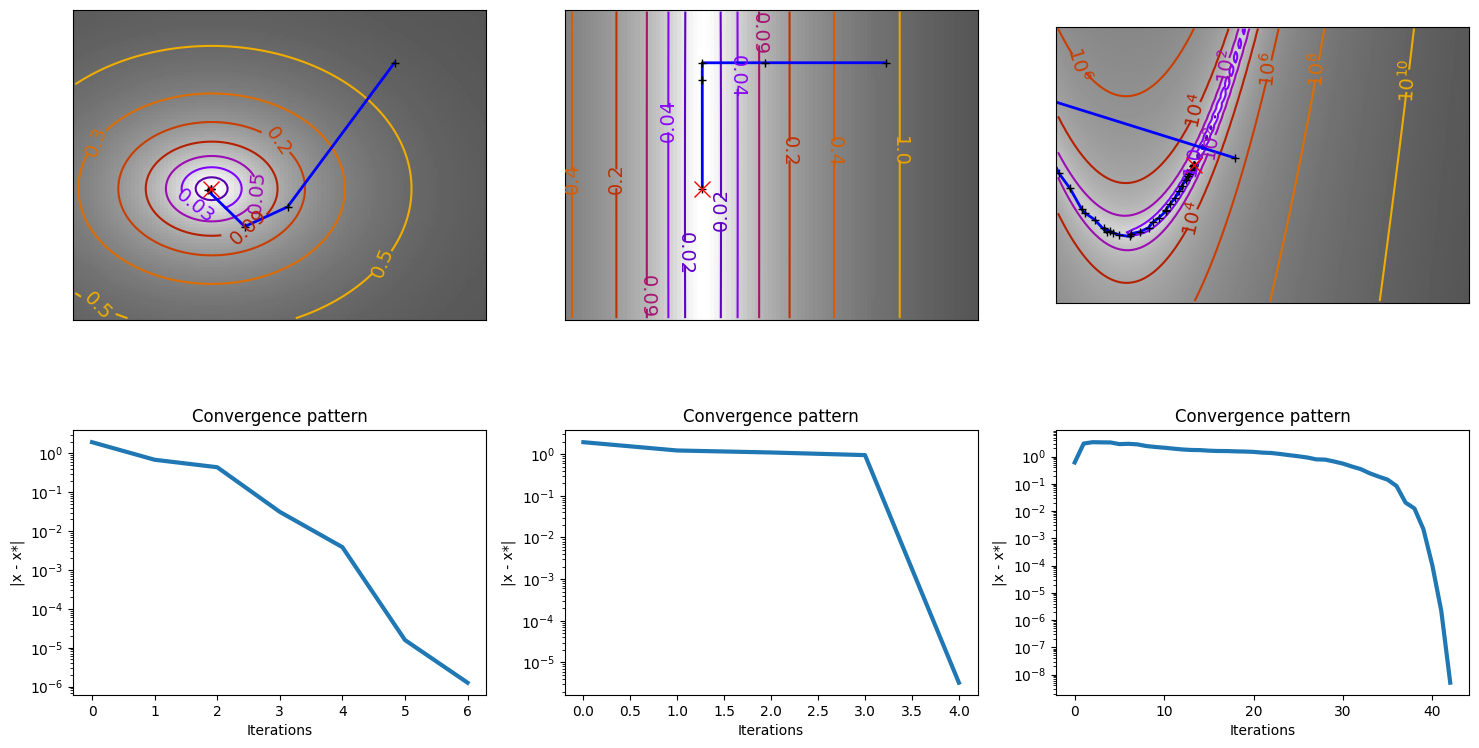

In [13]:
test_solver(bfgs)

WRITE YOUR COMMENTS HERE

We observe that BFGS and DFP have almost the same paths of convergence for the 3 functions, but BFGS is much faster than DFP, by looking at the number of iterations. Also, BFGS is much less sensitive than DFP to the use of approximate step size.

# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [14]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    # TODO : first loop
    for i in reversed(range(len(s_list))):
        alpha = mu_list[i] * np.dot(s_list[i], q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)
    r = np.dot(B0, q)
    # TODO: second loop
    for i in range(len(s_list)):
        beta = mu_list[i] * np.dot(y_list[i], r)
        r += s_list[i] * (alpha_list[len(s_list)-1-i] - beta)
    return -r

In [15]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2

    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation

    grad_x = f_grad(x)

    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):

        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(
            f, f_grad, x, d, grad_x, c1=c1, c2=c2
        )

        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print(
                "iter: %d, f: %.6g, l_inf_norm(grad): %.6g"
                % (k, new_f, l_inf_norm_grad)
            )

        if l_inf_norm_grad < 1e-6:
            break

        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


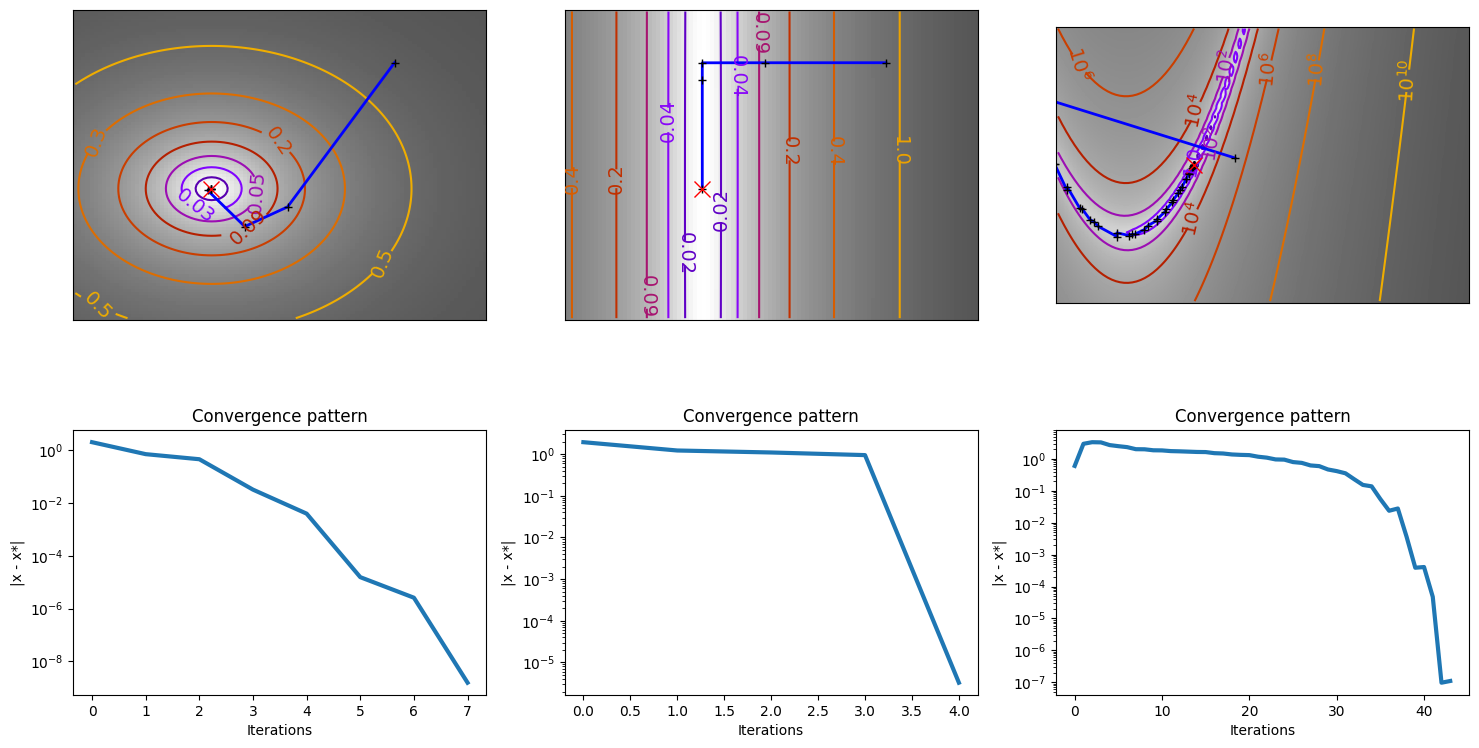

In [16]:
test_solver(lbfgs)

WRITE YOUR COMMENTS HERE

We can observe almost the same outcome as BFGS because L-BFGS can be regarded as an optimization algorithm for BFGS which optimizes the memory uses. The memory use is linear in the dimension of the problem. L-BFGS is more suitable for high dimension problems, but its convergence speed might be slower because of limited storage information.

---
---